## Implement and test Naive Bayes classifier

In [13]:
import sys
sys.path.append("/Users/andyreagan/tools/python/labMTsimple/")
from labMTsimple.speedy import *
from labMTsimple.storyLab import *

import re
import codecs
from os import listdir,mkdir
from os.path import isfile,isdir
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc,rcParams
rc("xtick", labelsize=8)
rc("ytick", labelsize=8)
rc("font",**{"family":"serif","serif":["cmr10"]})
# rc("text", usetex=True)
figwidth_onecol = 8.5
figwidth_twocol = figwidth_onecol/2

import numpy as np
from json import loads
import csv
from datetime import datetime,timedelta
import pickle

error_logging = True
sys.path.append("/Users/andyreagan/tools/python/kitchentable")
from dogtoys import *

In [25]:
def loadMovieReviews():
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]
    poswordcounts = dict()
    allwordcounts = dict()
    for file in posfiles:
        f = open(file,"r")
        postext = f.read() + " "
        f.close()
        dictify_general(postext,poswordcounts)
        dictify_general(postext,allwordcounts)
    negwordcounts = dict()
    for file in negfiles:
        f = open(file,"r")
        negtext = f.read() + " "
        f.close()
        dictify_general(negtext,negwordcounts)
        dictify_general(negtext,allwordcounts)

    print("there are {0} unique words in this corpus".format(len(allwordcounts)))

    # rip those dictionaries into lists for sorting
    allwordsList = [word for word in allwordcounts]
    allcountsList = [allwordcounts[allwordsList[i]] for i in range(len(allwordsList))]

    # sort them
    indexer = sorted(range(len(allcountsList)), key=lambda k: allcountsList[k], reverse=True)
    allcountsListSorted = np.array([float(allcountsList[i]) for i in indexer])
    allwordsListSorted = [allwordsList[i] for i in indexer]

    return allcountsListSorted,allwordsListSorted

In [14]:
def bayes_score(all_counts,pos_params,neg_params,my_counts):
    # uses all_counts_1k
    # uses pos_params
    # uses neg_params

    # compute conditional
    prob_pos = my_counts*pos_params/(all_counts/sum(all_counts))
    prob_neg = my_counts*neg_params/(all_counts/sum(all_counts))
    # add these things up carefulls
    log_prob_pos = 0.0
    for p in prob_pos:
        if p > 0:
            log_prob_pos += np.log(p)
    log_prob_neg = 0.0
    for p in prob_neg:
        if p > 0:
            log_prob_neg += np.log(p)

    # normalize post-hoc
    p_d = log_prob_pos+log_prob_neg

    # return the difference
    # if > 0, positive review
    return log_prob_pos/p_d - log_prob_neg/p_d

In [15]:
def train_bayes(all_words_1k,poswordcounts,negwordcounts):
    """Train bayes classifier using sorted word list, and dictionaries of counts from the two classes. Return the parameters"""
    pos_counts = np.array([float(poswordcounts[word]) if word in poswordcounts else 0.0 for word in all_words_1k])
    neg_counts = np.array([float(negwordcounts[word]) if word in negwordcounts else 0.0 for word in all_words_1k])
    # print(pos_counts[:10])

    # smoothing parameter
    alpha = 1.0
    pos_params = (pos_counts+alpha)/(np.sum(pos_counts)+alpha*len(pos_counts))
    # print(pos_params[:10])

    neg_params = (neg_counts+alpha)/(np.sum(neg_counts)+alpha*len(neg_counts))
    # print(neg_params[:10])

    return pos_params,neg_params

In [27]:
def naive_bayes():
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    print(len(posfiles))
    print(len(negfiles))
    # randomly select N reviews for training
    training_size = 200

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    print(pos_files_training)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    print(neg_files_training)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    # classify all positive reviews
    print("positive reviews")
    correct_pos = np.zeros(len(posfiles)-training_size/2)
    for i,file in enumerate([posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]):
        f = open(file,"r")
        postext = f.read()
        f.close()
        my_poswordcounts = dict()
        dictify_general(postext,my_poswordcounts)
        my_pos_counts = np.array([float(my_poswordcounts[word]) if word in my_poswordcounts else 0.0 for word in all_words_1k])

        score = bayes_score(all_counts_1k,pos_params,neg_params,my_pos_counts)

        if score > 0:
            correct_pos[i] = 1

    pos_accuracy = sum(correct_pos)/len(correct_pos)
    print(sum(correct_pos)/len(correct_pos))

    # classify all negative reviews
    print("negative reviews")
    correct_neg = np.zeros(len(negfiles)-training_size/2)
    for i,file in enumerate([negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]):
        f = open(file,"r")
        negtext = f.read()
        f.close()
        my_wordcounts = dict()
        dictify_general(negtext,my_wordcounts)
        my_counts = np.array([float(my_wordcounts[word]) if word in my_wordcounts else 0.0 for word in all_words_1k])

        score = bayes_score(all_counts_1k,pos_params,neg_params,my_counts)

        if score < 0:
            # print("correct, score={0}".format(score))
            correct_neg[i] = 1

    neg_accuracy = sum(correct_neg)/len(correct_neg)
    print(sum(correct_neg)/len(correct_neg))

    print("overall accuracy: {0:.1f}".format((pos_accuracy+neg_accuracy)/2*100))
    

    allLengths = [                   1,   2,   3,   5,   7, 10, 15, 25, 40, 60, 80,100,150,250,400,600,900,]
    allSamples = [int(np.floor(1000-training_size/2)),2000,1500,1500,1000,900,750,600,500,250,100, 75, 75, 40, 25, 15,  1,]
    # allLengths = []

    files = [posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]

    # store all of the scores here
    pos_results_all = [[] for i in range(len(allLengths))]
    # store the mean of those here
    pos_means = [0.0 for i in range(len(allLengths))]
    # store the std of those here
    pos_std = [0.0 for i in range(len(allLengths))]

    for k,numReviews in enumerate(allLengths):
        numSamples = allSamples[k]
        print("pos: taking {0} samples of {1} reviews".format(numSamples,numReviews))

        if numReviews == 1:
            choose_randomly = False
        else:
            choose_randomly = True

        scores = [0.0 for i in range(numSamples)]
        for i in range(numSamples):
            # print("on sample {0}".format(i))

            if choose_randomly:
                my_files = np.random.choice(files,size=numReviews,replace=False)
            else:
                my_files = [files[i]]

            # forget the string expansion
            # let"s store them as a dict
            # allwordcounts = dict()
            # nah, let's store them as in the vector
            allwordcounts = np.zeros(len(all_counts_1k))
            for file in my_files:
                ########################################
                # this loads the files
                f = open(file,"r")
                rawtext = f.read()
                f.close()
                # add to the full dict
                # dictify_general(rawtext,allwordcounts)
                # add it to the vector
                my_list = listify(rawtext)
                for word in my_list:
                    if word in all_words_1k_dict:
                        allwordcounts[all_words_1k_dict[word]] += 1

            scores[i] = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

        # now save those scores
        pos_results_all[k] = scores
        pos_means[k] = np.mean(scores)
        print("mean score is {0}".format(pos_means[k]))
        pos_std[k] = np.std(scores)

    files = [negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]

    # store all of the scores here
    neg_results_all = [[] for i in range(len(allLengths))]
    # store the mean of those here
    neg_means = [0.0 for i in range(len(allLengths))]
    # store the std of those here
    neg_std = [0.0 for i in range(len(allLengths))]

    for k,numReviews in enumerate(allLengths):
        numSamples = allSamples[k]
        print("neg: taking {0} samples of {1} reviews".format(numSamples,numReviews))

        if numReviews == 1:
            choose_randomly = False
        else:
            choose_randomly = True

        scores = [0.0 for i in range(numSamples)]
        for i in range(numSamples):
            # print("on sample {0}".format(i))

            if choose_randomly:
                my_files = np.random.choice(files,size=numReviews,replace=False)
            else:
                my_files = [files[i]]


            # forget the string expansion
            # let"s store them as a dict
            # allwordcounts = dict()
            # nah, let's store them as in the vector
            allwordcounts = np.zeros(len(all_counts_1k))
            for file in my_files:
                ########################################
                # this loads the files
                f = open(file,"r")
                rawtext = f.read()
                f.close()
                # add to the full dict
                # dictify_general(rawtext,allwordcounts)
                # add it to the vector
                my_list = listify(rawtext)
                for word in my_list:
                    if word in all_words_1k_dict:
                        allwordcounts[all_words_1k_dict[word]] += 1

            scores[i] = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

        # now save those scores
        neg_results_all[k] = scores
        neg_means[k] = np.mean(scores)
        print("mean score is {0}".format(neg_means[k]))
        neg_std[k] = np.std(scores)

    # print(neg_results_all)
    # print(pos_results_all)
    print(neg_means)
    print(pos_means)
    print(neg_std)
    print(pos_std)

    overlapping = np.zeros(len(allLengths))
    for i in range(len(allLengths)):
        average_score = np.mean(neg_results_all[i]+pos_results_all[i])
        overlapping[i] = float(len(np.where(pos_results_all[i] < average_score)[0]) + len(np.where(neg_results_all[i] > average_score)[0])) / ( len( neg_results_all[i] ) + len( pos_results_all[i] ) )

    print(overlapping)

    fig = plt.figure()
    ax1 = fig.add_axes([0.15,0.2,0.7,0.7])
    ax1.plot(np.log10(allLengths),overlapping,linewidth=2,color="#ef8a62",)
    ax1.set_xlabel("log10(Number of Reviews)")
    ax1.set_ylabel("Fraction overlapping")
    # xlim with a little space
    ax1.set_xlim(np.log10([allLengths[0]-.1,allLengths[-1]+.1])) 
    ax1.set_title("Sentiment over many random samples for {0}".format("Naive Bayes"))
    # mysavefig("moviereviews-scores-{0}.png".format("naive-bayes"))
    mysavefig("moviereviews-scores-{0}.pdf".format("naive-bayes"),folder="../figures/NB")
    plt.close(fig)

    fig = plt.figure()
    ax1 = fig.add_axes([0.15,0.2,0.7,0.7])
    ax1.errorbar(np.log10(allLengths),pos_means,pos_std,linewidth=2,color="#ef8a62",)
    ax1.errorbar(np.log10(allLengths),neg_means,neg_std,linewidth=2,color="#2b8cbe",)
    ax1.legend(["Positive reviews","Negative reviews"],loc="best")
    ax1.set_xlabel("log10(Number of Reviews)")
    ax1.set_ylabel("Sentiment")
    # xlim with a little space
    ax1.set_xlim(np.log10([allLengths[0]-.1,allLengths[-1]+.1])) 
    # ax1.set_ylim([0,24])
    # plt.xticks([float(i)+0.5 for i in range(4)])
    # plt.yticks([float(i)+0.5 for i in range(3)])
    # ax1.set_xticklabels([1,5,25,50])
    # ax1.set_yticklabels([22,28,35])
    ax1.set_title("Sentiment over many random samples for {0}".format("Naive Bayes"))
    # mysavefig("moviereviews-{0}.png".format("naive-bayes"))
    mysavefig("moviereviews-{0}.pdf".format("naive-bayes"),folder="../figures/NB")
    plt.close(fig)

In [31]:
def NB_on_NYT():
    """Train NB on movie reviews, test it on NYT Society section."""

    print("training")
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    # randomly select N reviews for training
    training_size = 200

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    # above from naive_bayes() function
    # now get the NYT section loaded
    print("loading NYT")
    sections = ["arts","books","classified","cultural","editorial","education","financial","foreign","home","leisure","living","magazine","metropolitan","movies","national","regional","science","society","sports","style","television","travel","week-in-review","weekend",]
    scores = np.zeros(len(sections))
    for i,section in enumerate(sections):
        a = pickle.load( open("../data/nyt/sections/NYT_{0}.dict".format(section), "rb") )

        allwordcounts = np.zeros(len(all_counts_1k))
        for word in a:
            if word in all_words_1k_dict:
                allwordcounts[all_words_1k_dict[word]] = a[word]

        print("scoring")
        score = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)
        print("{0} score={1}".format(section,score))
        scores[i] = score
    indexer = sorted(range(len(scores)),key=lambda k: scores[k],reverse=True)
    sections_sorted = [sections[i] for i in indexer]
    my_happs_sorted = np.array([scores[i] for i in indexer])
    print(sections_sorted)

    avg_happs_unweighted = my_happs_sorted.mean()

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_axes([.2,.2,.7,.7])
    # ax.bar(np.arange(len(sections)),np.array(my_happs_sorted),orientation="vertical")
    # ax.bar(0,.8,np.array(my_happs_sorted)-avg_happs,bottom=np.arange(len(sections)),orientation="horizontal")
    bar_height = 0.8
    happs_diff = np.array(my_happs_sorted)-avg_happs_unweighted
    rects1 = ax.bar(0,bar_height,happs_diff,bottom=np.arange(len(sections)),orientation="horizontal")
    ax.set_ylim([bar_height-1,len(sections)])
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlabel("Happs diff from unweighted average")
    ax.set_title("Ranking of NYT Sections by {0}".format("NB"))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            width = rect.get_width()
            y = int(np.floor(rect.get_y()))

            x = rect.get_x()
            if happs_diff[y] > 0:
                ax.text(-0.0005, y+bar_height/2., "{0}. {1}".format(y+1,sections_sorted[y].capitalize()),
                        ha="right", va="center")
            else:
                ax.text(.0005, y+bar_height/2., "{0}. {1}".format(y+1,sections_sorted[y].capitalize()),
                        ha="left", va="center")

    autolabel(rects1)

    # mysavefig("NYT-sorted-{0}.png".format("NB"))
    mysavefig("NYT-sorted-{0}.pdf".format("NB"),folder="../figures/nyt")



In [75]:
def NB_wordshift(q=False):
    print("training")
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    # randomly select N reviews for training
    training_size = 200

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    my_counts = np.ones(len(all_counts_1k))
    # given a text word vector my_counts, the unweighted probabilities are this
    prob_pos = my_counts*pos_params/(all_counts_1k/sum(all_counts_1k))
    prob_neg = my_counts*neg_params/(all_counts_1k/sum(all_counts_1k))
    # really just each vector multiplied together
    # but we take the log, and sum (for floating point-ness)
    
    # now let's normalize this, per peer request:
    prob_pos = prob_pos/prob_pos.sum()
    prob_neg = prob_neg/prob_neg.sum()

    # using 1's, and taking the max of the ratios will give the most informative
    ratio_pos = prob_pos/prob_neg
    ratio_neg = prob_neg/prob_pos

    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_pos[k],reverse=True)
    ratio_pos_sorted = [ratio_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_neg[k],reverse=True)
    ratio_neg_sorted = [ratio_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]
    
    movie_results = [[],[],[],[]]

    if not q:
        print("-"*80)
        print("-"*80)
        print("top positive words:")
    for i in range(10):
        movie_results[0].append([ratio_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        movie_results[1].append([ratio_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    # using 1's, and taking the max of the ratios will give the most informative
    diff_pos = prob_pos-prob_neg
    diff_neg = prob_neg-prob_pos

    indexer = sorted(range(len(diff_pos)),key=lambda k: diff_pos[k],reverse=True)
    diff_pos_sorted = [diff_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(diff_neg)),key=lambda k: diff_neg[k],reverse=True)
    diff_neg_sorted = [diff_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]

    if not q:
        print("top positive words:")
    for i in range(10):
        movie_results[2].append([diff_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        movie_results[3].append([diff_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)
    
    section="society"
    a = pickle.load( open("../data/nyt/sections/NYT_{0}.dict".format(section), "rb") )

    allwordcounts = np.zeros(len(all_counts_1k))
    for word in a:
        if word in all_words_1k_dict:
            allwordcounts[all_words_1k_dict[word]] = a[word]

    prob_pos = allwordcounts*pos_params/(all_counts_1k/sum(all_counts_1k))
    prob_neg = allwordcounts*neg_params/(all_counts_1k/sum(all_counts_1k))
    
    # now let's normalize this, per peer request:
    prob_pos = prob_pos/prob_pos.sum()
    prob_neg = prob_neg/prob_neg.sum()

    # using 1's, and taking the max of the ratios will give the most informative
    ratio_pos = prob_pos/prob_neg
    ratio_neg = prob_neg/prob_pos

    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_pos[k],reverse=True)
    ratio_pos_sorted = [ratio_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_neg[k],reverse=True)
    ratio_neg_sorted = [ratio_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]
    
    times_results = [[],[],[],[]]

    if not q:
        print("-"*80)
        print("-"*80)
        print("top positive words:")
    for i in range(10):
        times_results[0].append([ratio_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        times_results[1].append([ratio_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    # using 1's, and taking the max of the ratios will give the most informative
    diff_pos = prob_pos-prob_neg
    diff_neg = prob_neg-prob_pos

    indexer = sorted(range(len(diff_pos)),key=lambda k: diff_pos[k],reverse=True)
    diff_pos_sorted = [diff_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(diff_neg)),key=lambda k: diff_neg[k],reverse=True)
    diff_neg_sorted = [diff_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]

    if not q:
        print("top positive words:")
    for i in range(10):
        times_results[2].append([diff_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        times_results[3].append([diff_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    score = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

    if not q:
        print("{0} score={1}".format(section,score))
    
    return movie_results,times_results

In [19]:
def bayes_many_samples(n_trials):
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    results = [0.0 for i in range(n_trials)]
    n_stopwords = 0

    for trial_i in range(n_trials):

        print(len(posfiles))
        print(len(negfiles))
        # randomly select N reviews for training
        training_size = 200
    
        pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
        print(pos_files_training)
        # go add up all the words for training
        poswordcounts = dict()
        for file in [posfiles[i] for i in pos_files_training]:
            f = open(file,"r")
            postext = f.read()
            f.close()
            dictify_general(postext,poswordcounts)
        # select the negative reviews for training
        neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
        print(neg_files_training)
        # go add up the words
        negwordcounts = dict()
        for file in [negfiles[i] for i in neg_files_training]:
            f = open(file,"r")
            negtext = f.read()
            f.close()
            dictify_general(negtext,negwordcounts)
    
        all_counts,all_words = loadMovieReviews()
        # take the top 1000 words
        all_counts_1k = all_counts[n_stopwords:5000]
        all_words_1k = all_words[n_stopwords:5000]
        # build this for speed later
        all_words_1k_dict = dict()
        for i,word in enumerate(all_words_1k):
            all_words_1k_dict[word] = i
    
        pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)
    
        # classify all positive reviews
        print("positive reviews")
        correct_pos = np.zeros(len(posfiles)-training_size/2)
        for i,file in enumerate([posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]):
            f = open(file,"r")
            postext = f.read()
            f.close()
            my_poswordcounts = dict()
            dictify_general(postext,my_poswordcounts)
            my_pos_counts = np.array([float(my_poswordcounts[word]) if word in my_poswordcounts else 0.0 for word in all_words_1k])
    
            score = bayes_score(all_counts_1k,pos_params,neg_params,my_pos_counts)
    
            if score > 0:
                correct_pos[i] = 1
    
        pos_accuracy = sum(correct_pos)/len(correct_pos)
        print(sum(correct_pos)/len(correct_pos))
    
        # classify all negative reviews
        print("negative reviews")
        correct_neg = np.zeros(len(negfiles)-training_size/2)
        for i,file in enumerate([negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]):
            f = open(file,"r")
            negtext = f.read()
            f.close()
            my_wordcounts = dict()
            dictify_general(negtext,my_wordcounts)
            my_counts = np.array([float(my_wordcounts[word]) if word in my_wordcounts else 0.0 for word in all_words_1k])
    
            score = bayes_score(all_counts_1k,pos_params,neg_params,my_counts)
    
            if score < 0:
                # print("correct, score={0}".format(score))
                correct_neg[i] = 1
    
        neg_accuracy = sum(correct_neg)/len(correct_neg)
        print(sum(correct_neg)/len(correct_neg))
    
        print("overall accuracy: {0:.1f}".format((pos_accuracy+neg_accuracy)/2*100))
        results[trial_i] = (pos_accuracy+neg_accuracy)/2*100
        
    print(np.mean(results))



In [28]:
naive_bayes()

1000
1000
[761 523 507 693  60 597 453  28 853 270 118 127 374 590 754 941 940 248
 183 445 117 820 678  43 675 313 526 240 490 432 751 672 312 558  96 111
 980 832 959 139 229 615 465 443 730 522 883  65 925 643 942 469 504 391
 612 899 887 963 340 474  82 829 145 620 834 399 907 376   9 531  39 278
 477 551 901 630 965  31  86 692  62 216 669 244 471 720 156 227 714 848
 825  21 564 788  38 992 553 704 798 707]
[ 22 579  26 262 880 574 824 416 552 336 785 689 839 157 587 350 343  64
 522 413   1 401 868 692 164 179   7 730 435  51 797  29 956 903  66 886
 659 279 970 775  34 870 473 632 891 308 863 191 827 667 428 506 404 609
 895 483 357 943 739 422 873 961  95  92 407 861 411 679 911 746 440 311
 927  61 439 545 380 340 119 563 171 635  76 441 180 625 637 558 509 468
 753 293 384 436 788  57 514  80 808 146]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus
positive reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.797777777778
negative reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.714444444444
overall accuracy: 75.6
pos: taking 900 samples of 1 reviews
mean score is 0.3017582361623197
pos: taking 2000 samples of 2 reviews
mean score is 0.1403971684898872
pos: taking 1500 samples of 3 reviews
mean score is 0.11034835924242371
pos: taking 1500 samples of 5 reviews
mean score is 0.08854013358847249
pos: taking 1000 samples of 7 reviews
mean score is 0.07357304813942502
pos: taking 900 samples of 10 reviews
mean score is 0.06461946056958803
pos: taking 750 samples of 15 reviews
mean score is 0.053409946868337034
pos: taking 600 samples of 25 reviews
mean score is 0.04152686155050998
pos: taking 500 samples of 40 reviews
mean score is 0.03107676382717013
pos: taking 250 samples of 60 reviews
mean score is 0.024137089788770816
pos: taking 100 samples of 80 reviews
mean score is 0.01991244882912512
pos: taking 75 samples of 100 reviews
mean score is 0.01651506549022935
pos: taking 75 samples of 150 reviews
mean score is 0.01186107011427974
pos: taking 40 samples of 2

In [29]:
bayes_many_samples(10)

1000
1000
[351 897 592 510  91 721 572 273 504 625 735 725 393 930 502 815 131 926
 499 871  97 632 200 959 500 828  44 494 127 488 684 800 152  66  60 130
 621  14 669  59 156 687 125 432  21  71 448 414 445 412 444  81  57 271
 694 506  47 483 336 145 839 465 458 505 492 119 895 980 489  76 927 258
 366 123 730 819 854 727 237 670  11 306 641 288 314 101 295 820 887 265
 471 223 173 216 186 342  87 629 468 129]
[266 347 571 632 597 546 236 134 870 988  46 360 349 230  65 208 452 286
 847 907 382 562 184 169 998 155 700 817 164 593 419 840 693 661 880 621
 109 899 963 545 885 270 695 190 470 773 218 878 765 576 345 357  38  97
 779 523 900 881 552 374 219 915 398  42 104 105  70 557 272 403 390 281
 247 911  78 914 492 490 659 363 872  20 305 474 933 554  64 172 778 540
 827 944 180 860 809 710 791 775 316 801]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus
positive reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.644444444444
negative reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.833333333333
overall accuracy: 73.9
1000
1000
[ 92 841 177 240 788 134 368 971 918 443 491 929 664 890 305  75 989 774
 313  23 952 662 845 172   9 687 358 638 310 775 309 112  15 126 100 579
  86 220 583 604 191 471 936 388 705 459 610 797 791  32 422 110  38 562
 271 954 927 656 109 916 983  65 334 607 436 718  50 517  45 939 633 407
  28 262 965 591 219 500 449 101 234 754 453  10 498  52 683 333  22 131
 180  39 510 378 566 995 858 133 367 208]
[952 314 431 982 700 838 540 737 375 872 392 589 973 374 155  29 795 593
 866 929 996 550 794 117 688 105 141 398 133 736 899 303 305 796 667 342
 984  17  76 490 935 294 680 368 658 108 717 601 845 653  90 397 318 918
  40 171 317 249 172 287 325 785 770 923 299 465 903 466 798 221 300 112
 577 185 439 230 854  33  66  38 168 253 630 384 948 861 946 389 919 636
 201 424 817 605 306 528 208 440 265 386]
there are 49910 unique words in this corpus
positive reviews
0.651111111111
negative reviews
0.874444444444
overall accuracy: 76.3
1000
10

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus
loading NYT
scoring
arts score=0.0011159275640186261
scoring
books score=0.0012200187812716479
scoring
classified score=0.0015993922267443228
scoring
cultural score=0.001261138308587706
scoring
editorial score=0.0012472466907665902
scoring
education score=0.011667700557933758
scoring
financial score=0.0011334191940998717
scoring
foreign score=0.0011420095448818057
scoring
home score=0.0017423632375913045
scoring
leisure score=0.0015426128702282216
scoring
living score=0.001899736991112455
scoring
magazine score=0.0013857617664865818
scoring
metropolitan score=0.0010941508039481462
scoring
movies score=0.001398978836208764
scoring
national score=0.0011498957790482822
scoring
regional score=0.001148435935058978
scoring
science score=0.0016449263342612763
scoring
society score=0.0016969451543734082
scoring
sports score=0.0011298850088227175
scoring
style score=0.0014925479144223819
scoring
television score=0.07792182991749835
scoring
travel scor

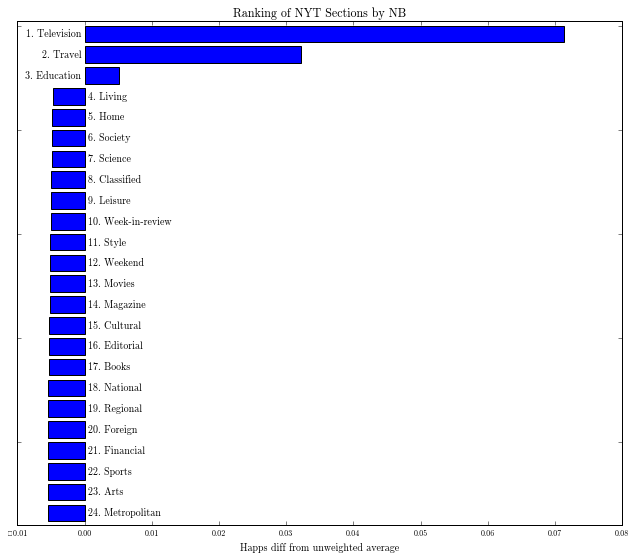

In [32]:
NB_on_NYT()

In [42]:
mr,tr = NB_wordshift()

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
top positive words:
trek: 22.23155849829559
rocky: 22.231558498295588
mallory: 19.452613686008643
shrek: 17.599983811150675
contact: 16.673668873721688
marie: 16.673668873721688
altman: 14.821038998863726
julianne: 14.821038998863724
animated: 11.115779249147796
lebowski: 11.115779249147796
--------------------------------------------------------------------------------
top negative words:
mars: 18.35228960809382
horrible: 17.27274316055889
gorilla: 16.193196713023966
cindy: 16.193196713023966
batman: 13.674255002109119
fault: 12.95455737041917
bats: 12.954557370419169
eastwood: 12.954557370419169
godzilla: 12.414784146651701
martha: 11.87501092288424
--------------------------------------------------------------------------------
-----------------------------------------------------

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:117: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:118: RuntimeWarning: invalid value encountered in true_divide


In [43]:
mr

[[[22.231558498295591, 'trek'],
  [22.231558498295588, 'rocky'],
  [19.452613686008643, 'mallory'],
  [17.599983811150675, 'shrek'],
  [16.673668873721688, 'contact'],
  [16.673668873721688, 'marie'],
  [14.821038998863726, 'altman'],
  [14.821038998863724, 'julianne'],
  [11.115779249147796, 'animated'],
  [11.115779249147796, 'lebowski']],
 [[18.35228960809382, 'mars'],
  [17.272743160558889, 'horrible'],
  [16.193196713023966, 'gorilla'],
  [16.193196713023966, 'cindy'],
  [13.674255002109119, 'batman'],
  [12.95455737041917, 'fault'],
  [12.954557370419169, 'bats'],
  [12.954557370419169, 'eastwood'],
  [12.414784146651701, 'godzilla'],
  [11.87501092288424, 'martha']],
 [[0.0023184565606258548, 'mallory'],
  [0.0014769745243560189, 'marie'],
  [0.0014371265400795635, 'altman'],
  [0.0013892223220769112, 'julianne'],
  [0.0011732169010821849, 'dinosaurs'],
  [0.0010833532309152843, 'apostle'],
  [0.0010441877831829189, "friend's"],
  [0.0010098516458492538, 'fiona'],
  [0.001005630

In [72]:
def to_table(my_list,my_fname):
    f = open(my_fname,"w")
    for j in range(10):
        table_strings = [my_list[i][j] for i in range(4)]
        table_strings = ["{0:.2f} & {1}".format(my_list[i][j][0],my_list[i][j][1]) for i in range(2)]+["{0:.4f} & {1}".format(my_list[i][j][0],my_list[i][j][1]) for i in range(2,4)]
        full_string = " & ".join(table_strings)
        f.write(full_string)
        f.write(r" \\")
        f.write("\n")
    f.close()
        

In [73]:
to_table(mr,"../figures/NB/output-003-table-MR.tex")

In [74]:
to_table(tr,"../figures/NB/output-003-table-TR.tex")

In [76]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-004-table-MR.tex")
to_table(tr,"../figures/NB/output-004-table-TR.tex")

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide


In [77]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-005-table-MR.tex")
to_table(tr,"../figures/NB/output-005-table-TR.tex")

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide


In [78]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-006-table-MR.tex")
to_table(tr,"../figures/NB/output-006-table-TR.tex")

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 49910 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide
